In [ ]:
!pip install imutils

In [ ]:
pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aanchalsharma19","key":"3af773c8a9239c9d7e77b5357e759033"}'}

In [ ]:
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle/

In [ ]:
# Download dataset
!kaggle datasets download -d mohammadamireshraghi/blood-cell-cancer-all-4class


100% 1.67G/1.68G [00:20<00:00, 53.1MB/s]
100% 1.68G/1.68G [00:20<00:00, 87.3MB/s]


In [ ]:
import zipfile

In [ ]:
zip_file_path = '/content/blood-cell-cancer-all-4class.zip'

In [ ]:
zip_ref = zipfile.ZipFile(zip_file_path, 'r')

In [ ]:
zip_ref.extractall()

In [ ]:
from imutils import paths
import os
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split

import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import morphology
import time

import keras,math
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D,BatchNormalization
from keras.layers import Dense, Dropout
from keras.models import Model

import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

import tensorflow as tf
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn import metrics

# **Data Preparation and Storage**

Creating Temporary Folder

In [ ]:
!mkdir -p /content/prepared_data/benign
!mkdir -p /content/prepared_data/PreB
!mkdir -p /content/prepared_data/ProB
!mkdir -p /content/prepared_data/EarlyPreB

!mkdir -p /content/prepared_test/benign
!mkdir -p /content/prepared_test/PreB
!mkdir -p /content/prepared_test/ProB
!mkdir -p /content/prepared_test/EarlyPreB


Splitting data into testing data and training data (10/90)

In [ ]:
data_dir  = '/content/Blood cell Cancer [ALL]'
data_list = sorted(list(paths.list_images(data_dir)))

random.seed(88)
random.shuffle(data_list)

train_list, test_list = train_test_split(data_list, train_size=0.90, shuffle=True, random_state=88)

print('number of testing list -:',len(test_list))
print('number of training list-:',len(train_list))

number of testing list -: 325
number of training list-: 2917


In [ ]:
print('Number of samples in dataset:',len(list(paths.list_images("/content/Blood cell Cancer [ALL]"))),'\n')

print('Number of samples in each class:','\n')
print("#1 Benign ---------------:", len(list(paths.list_images("/content/Blood cell Cancer [ALL]/Benign"))))
print("#2 Malignant[Early PreB] :", len(list(paths.list_images("/content/Blood cell Cancer [ALL]/[Malignant] early Pre-B"))))
print("#3 Malignant[PreB] ------:", len(list(paths.list_images("/content/Blood cell Cancer [ALL]/[Malignant] Pre-B"))))
print("#4 Malignant[ProB] ------:", len(list(paths.list_images("/content/Blood cell Cancer [ALL]/[Malignant] Pro-B"))))

Number of samples in dataset: 3242 

Number of samples in each class: 

#1 Benign ---------------: 512
#2 Malignant[Early PreB] : 979
#3 Malignant[PreB] ------: 955
#4 Malignant[ProB] ------: 796


Preparation and storage of test data

In [ ]:
p = 0

for img in test_list[:]:
    i = cv2.imread(img)
    i = cv2.resize(i, (224, 224))
    label = img.split(os.path.sep)[3]


    if label == "Benign":
        folder_path = ('/content/prepared_test/benign/'+label+str(p)+'.png')
    elif label == "[Malignant] Pre-B":
        folder_path = ('/content/prepared_test/PreB/'+label+str(p)+'.png')
    elif label == "[Malignant] Pro-B":
        folder_path = ('/content/prepared_test/ProB/'+label+str(p)+'.png')
    elif label == "[Malignant] early Pre-B":
        folder_path = ('/content/prepared_test/EarlyPreB/'+label+str(p)+'.png')

    p += 1
    cv2.imwrite(folder_path, i)


In [ ]:
p=0
tic = time.perf_counter()

for img in train_list[:]:

    i= cv2.imread(img)
    i= cv2.resize(i,(224,224))
    lable= img.split(os.path.sep)[3]

    if (lable=="Benign"):
        b= ('/content/prepared_data/benign/'+lable+str(p)+'.png')
    if (lable=="[Malignant] Pre-B"):
        b= ('/content/prepared_data/PreB/'+lable+str(p)+'.png')
    if (lable=="[Malignant] Pro-B"):
        b= ('/content/prepared_data/ProB/'+lable+str(p)+'.png')
    if (lable=="[Malignant] early Pre-B"):
        b= ('/content/prepared_data/EarlyPreB/'+lable+str(p)+'.png')
    p+=1
    cv2.imwrite(b,i)

    #-------- Segmentation ---------
    i= cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    i_lab = cv2.cvtColor(i, cv2.COLOR_RGB2LAB)        #RGB -> LAB
    l,a,b = cv2.split(i_lab)
    i2 = a.reshape(a.shape[0]*a.shape[1],1)
    km= KMeans(n_clusters=7, random_state=0).fit(i2)  #Clustring
    p2s= km.cluster_centers_[km.labels_]
    ic= p2s.reshape(a.shape[0],a.shape[1])
    ic = ic.astype(np.uint8)
    r,t = cv2.threshold(ic,141,255 ,cv2.THRESH_BINARY) #Binary Thresholding
    fh = ndi.binary_fill_holes(t)                      #fill holes
    m1 = morphology.remove_small_objects(fh, 200)
    m2 = morphology.remove_small_holes(m1,250)
    m2 = m2.astype(np.uint8)
    out = cv2.bitwise_and(i, i, mask=m2)

    if (lable=="Benign"):
        b= ('/content/prepared_data/benign/'+lable+str(p)+'.png')
    if (lable=="[Malignant] Pre-B"):
        b= ('/content/prepared_data/PreB/'+lable+str(p)+'.png')
    if (lable=="[Malignant] Pro-B"):
        b= ('/content/prepared_data/ProB/'+lable+str(p)+'.png')
    if (lable=="[Malignant] early Pre-B"):
        b= ('/content/prepared_data/EarlyPreB/'+lable+str(p)+'.png')
    p+=1
    out= cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
    cv2.imwrite(b,out)

toc2 = time.perf_counter()
print(f"2917 samples processed in { ((toc2 - tic)/60) } minutes")

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/py

2917 samples processed in 12.609220714633329 minutes


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


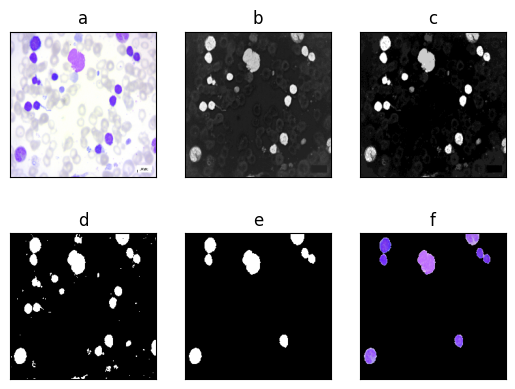

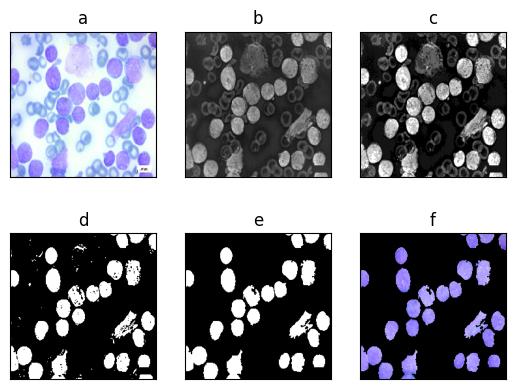

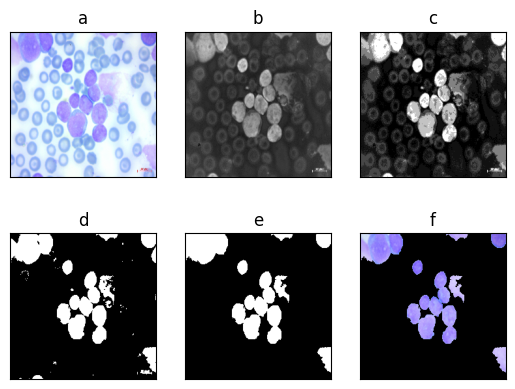

In [ ]:
#----- print some samples of training dataset -------

n= 3

o_img=[]
a_img=[]
c_img=[]
b_img=[]
m_img=[]
out_img=[]

random.seed(865)
random.shuffle(data_list)

for img in data_list[:n]:
    i= cv2.imread(img)
    i= cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    i= cv2.resize(i,(224,224))
    o_img.append(i)
    i_lab = cv2.cvtColor(i, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(i_lab)
    a_img.append(a)
    i2 = a.reshape(a.shape[0]*a.shape[1],1)
    km= KMeans(n_clusters=7, random_state=0).fit(i2)
    p2s= km.cluster_centers_[km.labels_]
    ic= p2s.reshape(a.shape[0],a.shape[1])
    ic = ic.astype(np.uint8)
    c_img.append(ic)
    r,t = cv2.threshold(ic,141,255 ,cv2.THRESH_BINARY)
    b_img.append(t)
    fh = ndi.binary_fill_holes(t)
    m1 = morphology.remove_small_objects(fh, 200)
    m2 = morphology.remove_small_holes(m1,250)
    #m2 = ndi.binary_fill_holes(m2)
    #m1 = m1.astype(np.uint8)
    #m1_imgs.append(m1)
    m2 = m2.astype(np.uint8)
    m_img.append(m2)
    out = cv2.bitwise_and(i, i, mask=m2)
    out_img.append(out)

for j in range(n):
    for t in range(1):
        #print('=>',j+1,':')
        plt.subplot(2,3,1+t),plt.imshow(o_img[j])
        plt.title('a'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,2+t),plt.imshow(a_img[j],'gray')
        plt.title('b'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,3+t),plt.imshow(c_img[j],'gray')
        plt.title('c'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,4+t),plt.imshow(b_img[j],'gray')
        plt.title('d'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,5+t),plt.imshow(m_img[j],'gray')
        plt.title('e'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,6+t),plt.imshow(out_img[j])
        plt.title('f'),plt.xticks([]),plt.yticks([])
    plt.show()

**Prepare data for training**

In [ ]:
#------- test Datafarame ---------

prepared_data_path = '/content/prepared_test'
prepared_data_list_filenames = (sorted(list(paths.list_images(prepared_data_path))))
random.shuffle(prepared_data_list_filenames)
prepared_data_list_labels = []

for line in prepared_data_list_filenames:
    prepared_data_list_labels.append(line.split(os.path.sep)[3])

I_series = pd.Series(prepared_data_list_filenames, name='filenames')
L_series = pd.Series(prepared_data_list_labels, name='labels')
test_df = pd.concat( [I_series, L_series], axis=1)

print('-- test Datafarame --')
print(test_df.head())
a=test_df['labels'].value_counts()
a

-- test Datafarame --
                                           filenames     labels
0  /content/prepared_test/EarlyPreB/[Malignant] e...  EarlyPreB
1  /content/prepared_test/PreB/[Malignant] Pre-B3...       PreB
2         /content/prepared_test/benign/Benign87.png     benign
3  /content/prepared_test/PreB/[Malignant] Pre-B1...       PreB
4  /content/prepared_test/EarlyPreB/[Malignant] e...  EarlyPreB


EarlyPreB    111
PreB          93
ProB          78
benign        43
Name: labels, dtype: int64

In [ ]:
#------- train/valid Datafarame -------

prepared_data_path = '/content/prepared_data'
prepared_data_list_filenames = (sorted(list(paths.list_images(prepared_data_path))))
random.shuffle(prepared_data_list_filenames)
prepared_data_list_labels = []

for line in prepared_data_list_filenames:
    prepared_data_list_labels.append(line.split(os.path.sep)[3])

I_series = pd.Series(prepared_data_list_filenames, name='filenames')
L_series = pd.Series(prepared_data_list_labels, name='labels')
df = pd.concat( [I_series, L_series], axis=1)

print('-- train/valid Datafarame --')

print(df.head())
a=df['labels'].value_counts()

-- train/valid Datafarame --
                                           filenames     labels
0  /content/prepared_data/EarlyPreB/[Malignant] e...  EarlyPreB
1       /content/prepared_data/benign/Benign3935.png     benign
2       /content/prepared_data/benign/Benign2971.png     benign
3  /content/prepared_data/ProB/[Malignant] Pro-B3...       ProB
4  /content/prepared_data/EarlyPreB/[Malignant] e...  EarlyPreB


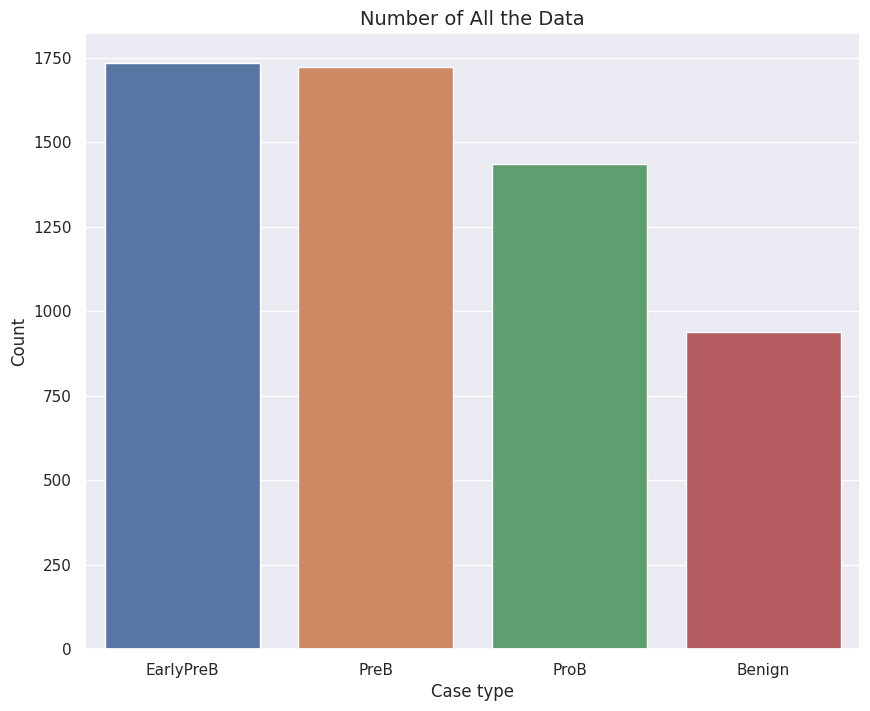

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
plt.figure(figsize=(10,8))
sns.barplot(x= ['EarlyPreB','PreB','ProB','Benign'], y= [a[0],a[1],a[2],a[3]])
plt.title('Number of All the Data', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [ ]:
SPLIT= 0.90

TRAIN_DF, VALID_DF = train_test_split(df, train_size=SPLIT, shuffle=True, random_state=88)

print('Train samples: ', len(TRAIN_DF))
print('Valid samples: ', len(VALID_DF))
print('Test samples : ', len(test_df))

Train samples:  5250
Valid samples:  584
Test samples :  325


In [ ]:
test_df['labels'].value_counts()

EarlyPreB    111
PreB          93
ProB          78
benign        43
Name: labels, dtype: int64

In [ ]:
BATCH_SIZE= 32
IMG_SHAPE= (224, 224, 3)
IMG_SIZE= (224, 224)

gen = ImageDataGenerator(rescale=1./255,
                         vertical_flip=True,
                         horizontal_flip=True)
                         #rotation_range=10)

gen2 = ImageDataGenerator(rescale=1./255)

train_gen = gen.flow_from_dataframe(TRAIN_DF,
                                    x_col= 'filenames',
                                    y_col= 'labels',
                                    target_size= IMG_SIZE,
                                    class_mode= 'categorical',
                                    color_mode= 'rgb',
                                    shuffle= True,
                                    batch_size= BATCH_SIZE,
                                    seed=88
)

valid_gen= gen2.flow_from_dataframe(VALID_DF,
                                    x_col= 'filenames',
                                    y_col= 'labels',
                                    target_size= IMG_SIZE,
                                    class_mode= 'categorical',
                                    color_mode= 'rgb',
                                    shuffle= True,
                                    batch_size= BATCH_SIZE,
                                    seed=88
)
test_gen= gen2.flow_from_dataframe(test_df,
                                   x_col= 'filenames',
                                   y_col= 'labels',
                                   target_size= IMG_SIZE,
                                   class_mode= 'categorical',
                                   color_mode= 'rgb',
                                   shuffle= True,
                                   batch_size= 325,
                                   seed=88
)


STEPS= int( len(train_gen.labels)/BATCH_SIZE)
print(STEPS)

Found 5250 validated image filenames belonging to 4 classes.
Found 584 validated image filenames belonging to 4 classes.
Found 325 validated image filenames belonging to 4 classes.
164


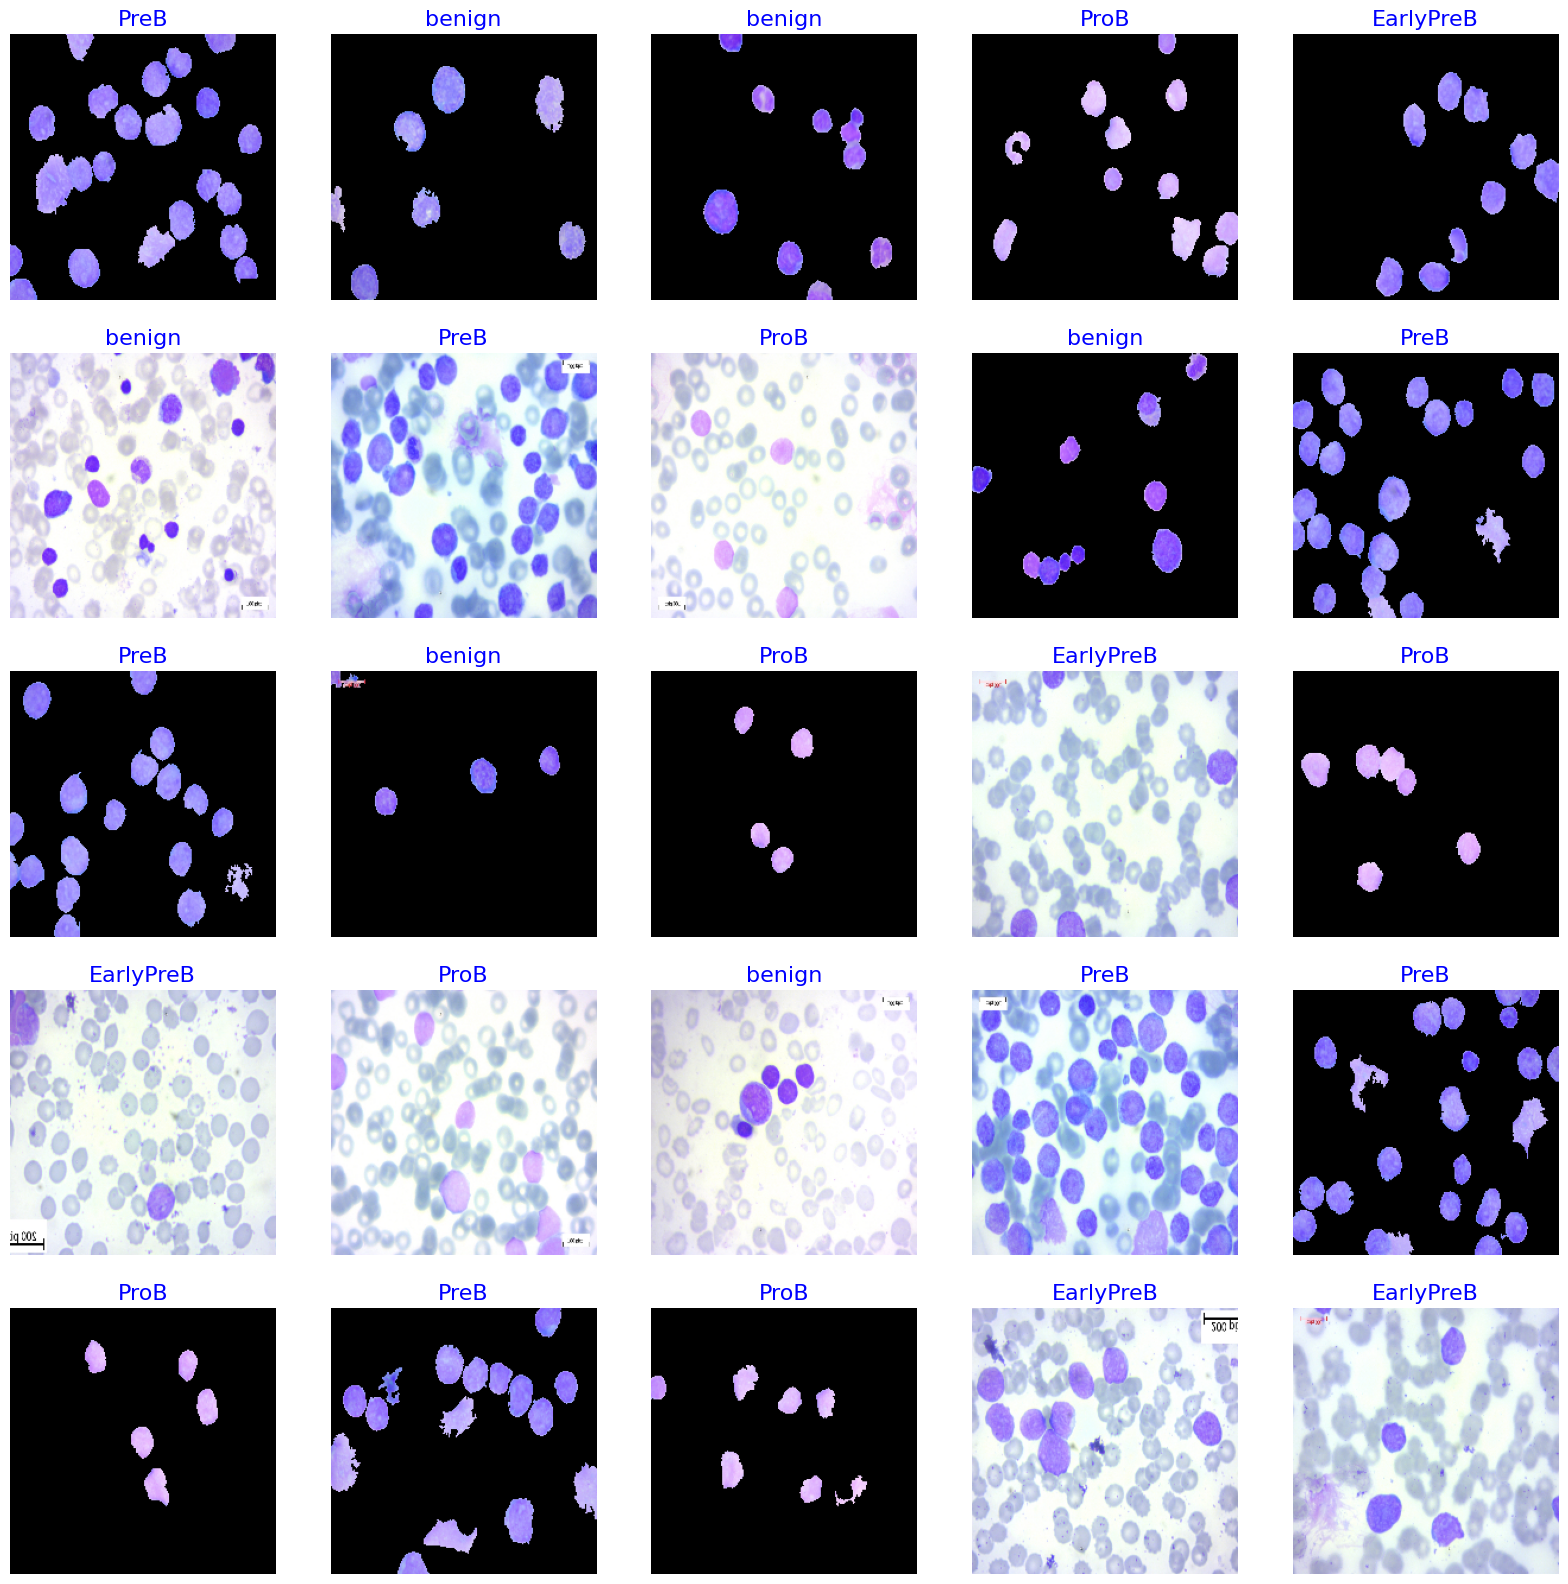

In [ ]:
#---- print 25 samples of trainig dataset -----

genn=train_gen
class_dictionary= genn.class_indices
class_names = list(class_dictionary.keys())
images, labels = next(genn)
plt.figure(figsize=(20,20))
length = len(labels)

if length<25:
    r=length
else:
    r=25

for i in range(r):
    plt.subplot(5, 5, i+1)
    image= (images[i])
    plt.imshow(image)
    index=np.argmax(labels[i])
    class_name= class_names[index]
    plt.title(class_name, color='blue', fontsize=16)
    plt.axis('off')
plt.show()

In [ ]:

base_model= tf.keras.applications.efficientnet.EfficientNetB0(include_top=False,weights='imagenet',input_shape=(224,224,3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
predictions = Dense(4, activation= "softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
print(base_model.input)
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                      

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=40,
    decay_rate=0.96,
    staircase=False)


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08), #optimizer=Adam(learning_rate=0.00001,decay = 10e-5),
              metrics=['accuracy'])
             # option = run_opts)

In [ ]:
history =         model.fit(x=train_gen,
                            epochs=15,
                            validation_data=valid_gen,
                            steps_per_epoch=None,
                            workers=2
                   )

Epoch 1/15
165/165 [==============================] - 97s 305ms/step - loss: 0.4171 - accuracy: 0.8442 - val_loss: 1.3993 - val_accuracy: 0.2449
Epoch 2/15
165/165 [==============================] - 46s 276ms/step - loss: 0.1525 - accuracy: 0.9448 - val_loss: 1.6206 - val_accuracy: 0.2654
Epoch 3/15
165/165 [==============================] - 46s 275ms/step - loss: 0.1188 - accuracy: 0.9585 - val_loss: 2.0624 - val_accuracy: 0.3236
Epoch 4/15
165/165 [==============================] - 47s 283ms/step - loss: 0.0862 - accuracy: 0.9695 - val_loss: 1.3804 - val_accuracy: 0.4675
Epoch 5/15
165/165 [==============================] - 47s 282ms/step - loss: 0.0696 - accuracy: 0.9756 - val_loss: 5.2025 - val_accuracy: 0.2260
Epoch 6/15
165/165 [==============================] - 47s 281ms/step - loss: 0.0567 - accuracy: 0.9806 - val_loss: 0.1457 - val_accuracy: 0.9555
Epoch 7/15
165/165 [==============================] - 46s 276ms/step - loss: 0.0514 - accuracy: 0.9844 - val_loss: 0.7604 - val_ac

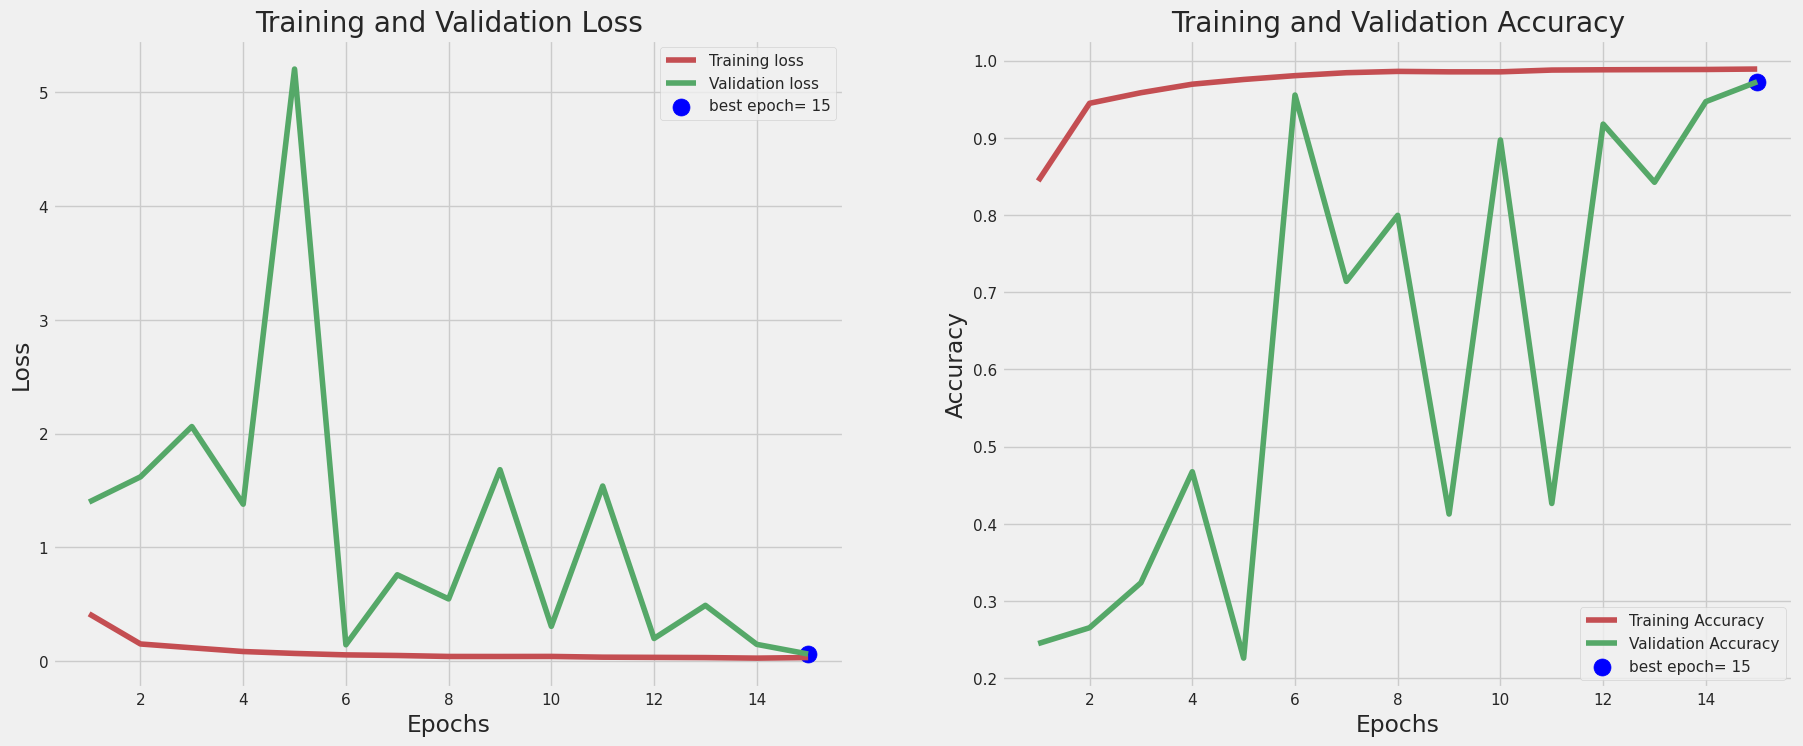

1/1 [==============================] - 5s 5s/step - loss: 0.0310 - accuracy: 0.9815
Model accuracy on test set: 98.1538474559784 (0, 255, 0) (55, 65, 80)


In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


tr_plot(history, 0)
acc=model.evaluate(test_gen,batch_size=32, steps=None, verbose=1)[1]*100
msg='Model accuracy on test set: ' + str(acc)
print(msg, (0,255,0), (55,65,80))

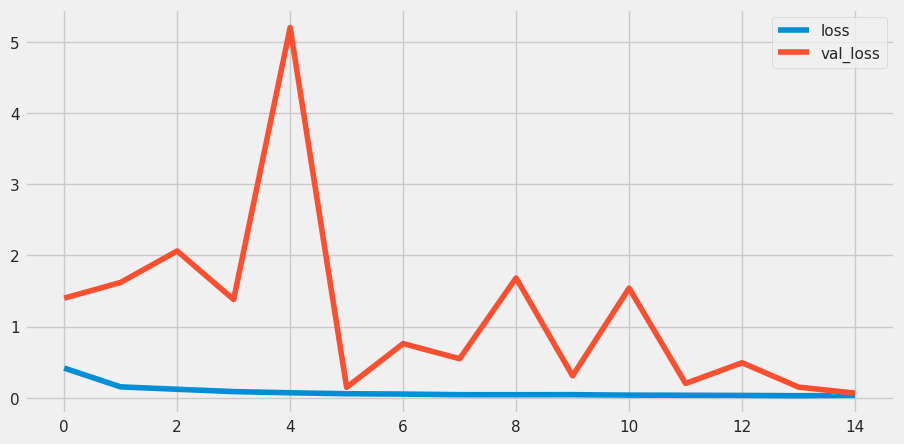

In [ ]:
# Plotting train_loss vs val_loss
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend()

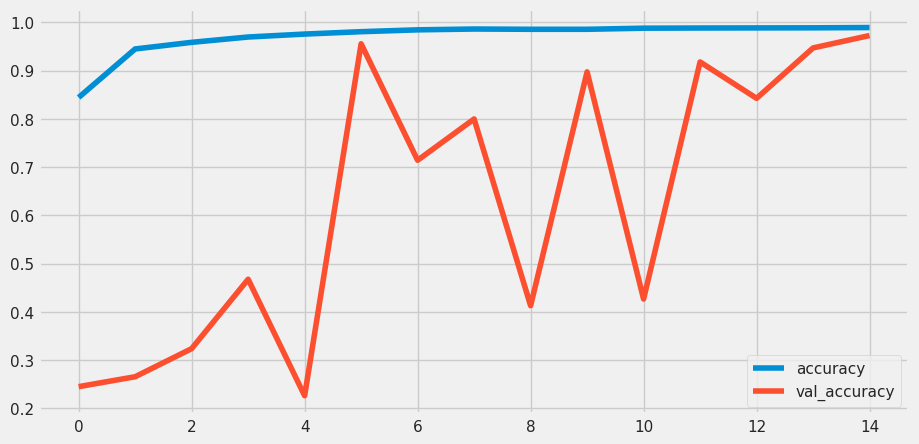

In [ ]:
# Plotting train_accuracy vs Val_accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history["accuracy"],label="accuracy")
plt.plot(history.history["val_accuracy"],label="val_accuracy")
plt.legend(loc='lower right')

In [ ]:
from sklearn.metrics import confusion_matrix


for X_batch, y_batch in test_gen:
    y_test = y_batch
    X_test = X_batch
    break

print('test label shape',y_test.shape)
print('test image shape',X_test.shape)
print('Evaluate on test-data:')
model.evaluate(X_test,y_test)

pred = model.predict(X_test)

bin_predict = np.argmax(pred,axis=1)
y_test = np.argmax(y_test,axis=1)


#Confusion matrix:
matrix = confusion_matrix(y_test, bin_predict)
print('Confusion Matrix:\n',matrix)

test label shape (325, 4)
test image shape (325, 224, 224, 3)
Evaluate on test-data:
11/11 [==============================] - 2s 62ms/step
Confusion Matrix:
 [[110   0   0   1]
 [  4  89   0   0]
 [  0   0  78   0]
 [  1   0   0  42]]


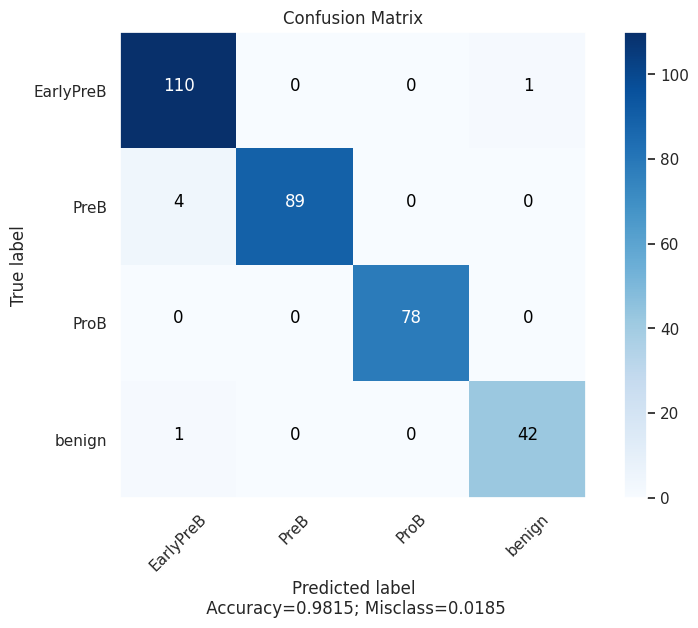

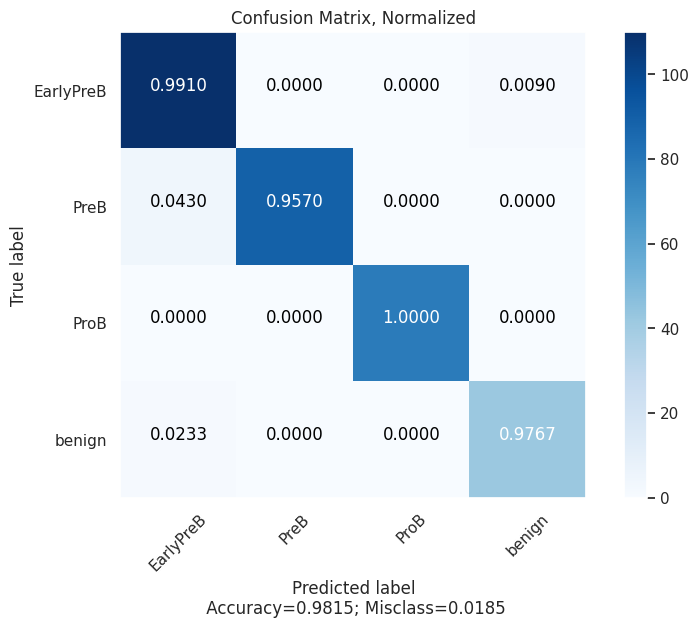

In [ ]:
import itertools

#Plot the Confusion matrix:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    sns.set(style="dark")
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n Accuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


plot_confusion_matrix(cm           = np.array(matrix),
                      normalize    = False,
                      target_names = ['EarlyPreB','PreB','ProB','benign'],
                      title        = "Confusion Matrix")

plot_confusion_matrix(cm           = np.array(matrix),
                      normalize    = True,
                      target_names = ['EarlyPreB','PreB','ProB','benign'],
                      title        = "Confusion Matrix, Normalized")



In [ ]:
class_metrics = metrics.classification_report(y_test,bin_predict,labels=[0, 1])
print(class_metrics)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       111
           1       1.00      0.96      0.98        93

   micro avg       0.98      0.98      0.98       204
   macro avg       0.98      0.97      0.98       204
weighted avg       0.98      0.98      0.98       204



In [ ]:
FP = matrix.sum(axis=0) - np.diag(matrix)
FN = matrix.sum(axis=1) - np.diag(matrix)
TP = np.diag(matrix)
TN = matrix[:].sum() - (FP + FN + TP)

TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)
FPR = FP/(FP+TN)
FNR = FN/(TP+FN)
FDR = FP/(TP+FP)

ACC = (TP+TN)/(TP+FP+FN+TN)

print('Other Metrics:')
MAE = mean_absolute_error(y_test, bin_predict)

print('MAE ----------------------------------------------:', MAE)
print('Accuracy -----------------------------------------:', ACC)
print('Precision (positive predictive value)-------------:', PPV)
print('Recall (Sensitivity, hit rate, true positive rate):', TPR)
print('Specificity (true negative rate)------------------:', TNR)
print('Negative Predictive Value-------------------------:', NPV)
print('Fall out (false positive rate)--------------------:', FPR)
print('False Negative Rate-------------------------------:', FNR)
print('False discovery rate------------------------------:', FDR)

Other Metrics:
MAE ----------------------------------------------: 0.03076923076923077
Accuracy -----------------------------------------: [0.98153846 0.98769231 1.         0.99384615]
Precision (positive predictive value)-------------: [0.95652174 1.         1.         0.97674419]
Recall (Sensitivity, hit rate, true positive rate): [0.99099099 0.95698925 1.         0.97674419]
Specificity (true negative rate)------------------: [0.97663551 1.         1.         0.9964539 ]
Negative Predictive Value-------------------------: [0.9952381  0.98305085 1.         0.9964539 ]
Fall out (false positive rate)--------------------: [0.02336449 0.         0.         0.0035461 ]
False Negative Rate-------------------------------: [0.00900901 0.04301075 0.         0.02325581]
False discovery rate------------------------------: [0.04347826 0.         0.         0.02325581]


11/11 [==============================] - 1s 67ms/step
Shape of preds:  (325, 4)


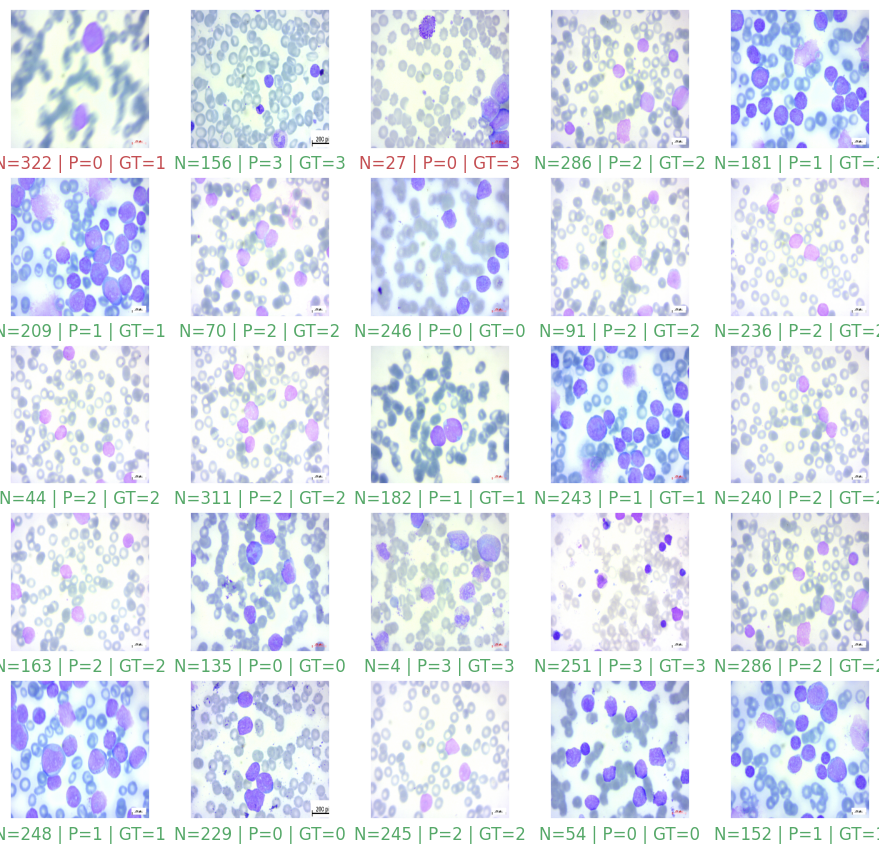

In [ ]:
preds = model.predict(X_test)
#print(preds)
print('Shape of preds: ', preds.shape)
plt.figure(figsize = (10, 10))

number = np.random.choice(preds.shape[0])

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    number = np.random.choice(preds.shape[0])
    pred = np.argmax(preds[number])
    actual = (y_test[number])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('N={} | P={} | GT={}'.format(number, pred, actual), color = col) #N= number P= prediction GT= actual (ground truth)
    image= X_test[number]#cv2.cvtColor(X_test[number], cv2.COLOR_BGR2RGB)
    plt.imshow(((image* 255).astype(np.uint8)), cmap='binary')
plt.show()

In [ ]:
!pip install joblib


In [ ]:
# Save the entire model to a file
model_file_path = '/content/my_efficientnet_model1.h5'
model.save(model_file_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
